# Compare latent space to high-dimensional space

In [1]:
import os
import pandas as pd
import sys
import numpy as np
from pandas.core.common import flatten
import pickle
import umap
from pathlib import Path
import datetime
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

In [2]:
from preprocessing_functions import pad_spectro, calc_zscore, create_padded_data
from evaluation_functions import get_knn, make_nn_stats_dict, make_statstabs

In [3]:
wd = os.getcwd()

DATA = os.path.join(os.path.sep, str(Path(wd).parents[0]), "data", "processed")
FIGURES = os.path.join(os.path.sep, str(Path(wd).parents[0]), "reports", "figures")

In [4]:
dftype = "reduced"
spec_df = pd.read_pickle(os.path.join(os.path.sep, DATA, "df_focal_"+dftype+".pkl"))

labels = spec_df.call_lable.values
calltypes = sorted(list(set(labels)))

specs = spec_df.spectrograms
specs = [calc_zscore(x) for x in specs]
original_embedding = create_padded_data(specs)

embedding = np.loadtxt(os.path.join(os.path.sep, DATA,'basic_UMAP_3D_reduced_default_params.csv'), delimiter=";")

## Compare embedding score S for different k's

In [20]:
# Make 5 UMAPs

n_times=5
embeddings_dict={}
for i in range(n_times):
    reducer = umap.UMAP(min_dist=0, metric= "euclidean", n_components = 3)
    embeddings_dict[i] = reducer.fit_transform(original_embedding)
  

In [30]:
# UMAP space

#ks = [1,3,5,8,10,15,20,30,40]
ks = [1,3,5,8,10,15,20,30,40,50,100,200]

metrics_tab = np.zeros((len(ks)*n_times,2))

i=0
for embedding in embeddings_dict.values():
    indices, distances = get_knn(np.max(np.asarray(ks)),embedding)
    for k_num,k in enumerate(ks):
        these_indices = [x[0:k] for x in indices]
        nn_stats_dict = make_nn_stats_dict(calltypes, labels, these_indices)
        stats_tab, stats_tab_norm = make_statstabs(nn_stats_dict, calltypes, labels, k)

        metrics_tab[i,0] = np.mean(np.diagonal(stats_tab.iloc[:-1,]))
        metrics_tab[i,1] = np.mean(np.diagonal(stats_tab_norm))
        i+=1
        
metrics_tab_df = pd.DataFrame(metrics_tab)
metrics_tab_df['k'] = ks*n_times
metrics_tab_df.columns = ['S', 'Snorm', 'k']

means_df = metrics_tab_df.groupby('k').mean()
stds_df = metrics_tab_df.groupby('k').std()


# Original space

metrics_tab_f = np.zeros((len(ks),2))

indices, distances = get_knn(np.max(np.asarray(ks)),original_embedding)

for k_num,k in enumerate(ks):
    these_indices = [x[0:k] for x in indices]
    nn_stats_dict = make_nn_stats_dict(calltypes, labels, these_indices)
    stats_tab, stats_tab_norm = make_statstabs(nn_stats_dict, calltypes, labels,k)

    metrics_tab_f[k_num,0] = np.mean(np.diagonal(stats_tab.iloc[:-1,]))
    metrics_tab_f[k_num,1] = np.mean(np.diagonal(stats_tab_norm))

metrics_tab_f_df = pd.DataFrame(metrics_tab_f)
metrics_tab_f_df['k'] = ks
metrics_tab_f_df.columns = ['S', 'Snorm', 'k']

In [31]:
# Original space

metrics_tab_f = np.zeros((len(ks),2))

indices, distances = get_knn(np.max(np.asarray(ks)),original_embedding)

for k_num,k in enumerate(ks):
    these_indices = [x[0:k] for x in indices]
    nn_stats_dict = make_nn_stats_dict(calltypes, labels, these_indices)
    stats_tab, stats_tab_norm = make_statstabs(nn_stats_dict, calltypes, labels,k)

    metrics_tab_f[k_num,0] = np.mean(np.diagonal(stats_tab.iloc[:-1,]))
    metrics_tab_f[k_num,1] = np.mean(np.diagonal(stats_tab_norm))

metrics_tab_f_df = pd.DataFrame(metrics_tab_f)
metrics_tab_f_df['k'] = ks
metrics_tab_f_df.columns = ['S', 'Snorm', 'k']

In [36]:
metrics_tab_f_df

,S,Snorm,k
0,70.685514,2.607156,1
1,67.492631,2.511618,3
2,65.586885,2.451023,5
3,63.885232,2.400733,8
4,62.943168,2.369164,10
5,60.973041,2.303188,15
6,59.706087,2.262391,20
7,57.469740,2.182281,30
8,55.728498,2.119245,40
9,54.406875,2.067839,50


In [37]:
means_df

,S,Snorm
k,,
1,63.842204,2.420716
3,62.344555,2.372834
5,61.605483,2.347721
8,60.591908,2.311939
10,60.121462,2.295688
15,59.270318,2.264199
20,58.597530,2.237855
30,57.394609,2.199427
40,56.457747,2.166019


/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/reports/figures/2021-07-08_comparison_to_original.jpg


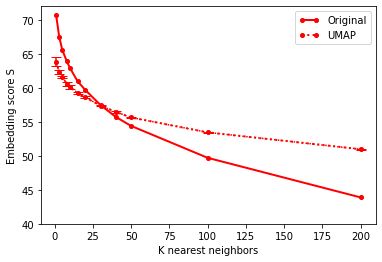

In [35]:
var ='S'

plt.plot(ks, metrics_tab_f_df[var], marker='o',linewidth=2, markersize=4, color ='red',label='Original')

plt.plot(ks, means_df[var], color = 'red', marker='o', linestyle='dotted', linewidth=2, markersize=4,label='UMAP')
plt.errorbar(ks, means_df[var], yerr=stds_df[var], linestyle='dotted', capsize=5, color = 'red')


plt.legend(numpoints=2)

plt.ylabel('Embedding score '+var)
plt.xlabel('K nearest neighbors')
plt.ylim(40,72)
outname=os.path.join(os.path.sep, FIGURES, datetime.datetime.today().strftime('%Y-%m-%d')+'_comparison_to_original.jpg')
print(outname)
plt.savefig(outname)

## Original space evaluation matrix

In [5]:
from evaluation_functions import nn, sil

In [6]:
nn_stats = nn(original_embedding, np.asarray(labels), k=5)

In [7]:
print("Log final metric (unweighted):",nn_stats.get_S())
print("Abs final metric (unweighted):",nn_stats.get_Snorm())

Log final metric (unweighted): 65.58688511753121
Abs final metric (unweighted): 2.4510227163786245


/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/reports/figures/heatS_UMAP_reduced_original.png


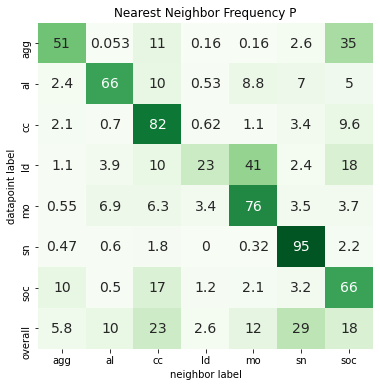

In [8]:
outname = os.path.join(os.path.sep, FIGURES, 'heatS_UMAP_'+dftype+'_original.png')
print(outname)
nn_stats.plot_heat_S(outname=outname)

/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/reports/figures/heatSnorm_UMAP_reduced_original.png


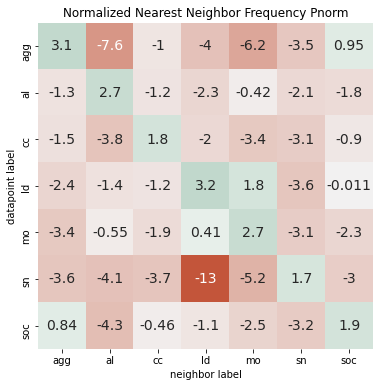

In [9]:
outname = os.path.join(os.path.sep, FIGURES, 'heatSnorm_UMAP_'+dftype+'_original.png')
print(outname)
nn_stats.plot_heat_Snorm(outname=outname)

In [10]:
nn_stats_umap = nn(embedding, np.asarray(labels), k=5)

In [12]:
import string

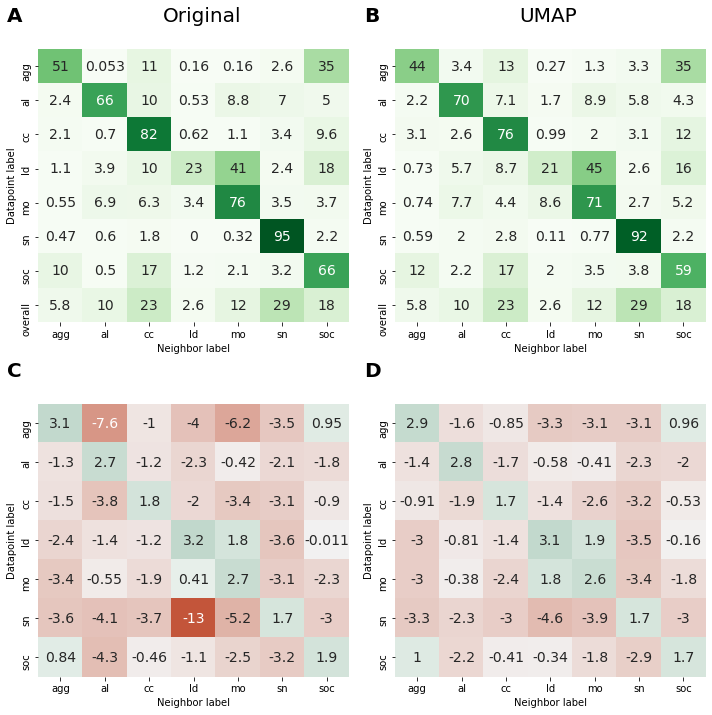

In [14]:
fig, axes = plt.subplots(2,2, figsize=(10,10))

norm_palette = sns.diverging_palette(20, 145, as_cmap=True)
abs_palette = sns.color_palette("Greens", as_cmap=True)

p1 = sns.heatmap(nn_stats.get_statstab(), annot=True, vmin=0, vmax=100, center=50, cmap=abs_palette, cbar=None, ax=axes[0][0], annot_kws={"size":14})
p1.set_xlabel("Neighbor label")
p1.set_ylabel("Datapoint label")
#p1.set_title("Normalized Nearest Neighbor Frequency Pnorm")
p1.text(-0.1, 1.1, string.ascii_uppercase[0], transform=axes[0][0].transAxes, 
      size=20, weight='bold')
p1.text(0.4, 1.1, "Original", transform=axes[0][0].transAxes, 
      size=20)


p2 = sns.heatmap(nn_stats_umap.get_statstab(), annot=True, vmin=0, vmax=100, center=50, cmap=abs_palette, cbar=None, ax=axes[0][1], annot_kws={"size":14})
p2.set_xlabel("Neighbor label")
p2.set_ylabel("Datapoint label")
#p2.set_title("Normalized Nearest Neighbor Frequency Pnorm")
p2.text(-0.1, 1.1, string.ascii_uppercase[1], transform=axes[0][1].transAxes, 
      size=20, weight='bold')     
p2.text(0.4, 1.1, "UMAP", transform=axes[0][1].transAxes, 
      size=20)
        
p3 = sns.heatmap(nn_stats.get_statstabnorm(), annot=True, vmin=-13, vmax=13, center=0, cmap=norm_palette, cbar=None, ax=axes[1][0], annot_kws={"size":14})
p3.set_xlabel("Neighbor label")
p3.set_ylabel("Datapoint label")
#p3.set_title("Normalized Nearest Neighbor Frequency Pnorm")
p3.text(-0.1, 1.1, string.ascii_uppercase[2], transform=axes[1][0].transAxes, 
      size=20, weight='bold')

p4 = sns.heatmap(nn_stats_umap.get_statstabnorm(), annot=True, vmin=-13, vmax=13, center=0, cmap=norm_palette, cbar=None, ax=axes[1][1], annot_kws={"size":14})
p4.set_xlabel("Neighbor label")
p4.set_ylabel("Datapoint label")
#p4.set_title("Normalized Nearest Neighbor Frequency Pnorm")
p4.text(-0.1, 1.1, string.ascii_uppercase[3], transform=axes[1][1].transAxes, 
      size=20, weight='bold')

plt.tight_layout()
plt.savefig(os.path.join(os.path.sep, FIGURES, 'paper_eval_matrices.png'), facecolor="white")

## Original space Silhouette plot

In [202]:
sil_stats = sil(original_embedding, labels)

/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/reports/figures/silplot_UMAP_reduced_original.png


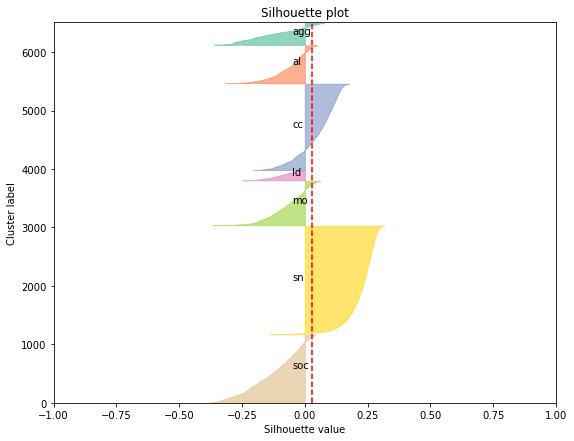

In [39]:
outname = os.path.join(os.path.sep, FIGURES, 'silplot_UMAP_'+dftype+'_original.png')

print(outname)
sil_stats.plot_sil(outname=outname)

In [40]:
sil_stats.get_avrg_score()

0.0298155402510341

In [203]:
sil_stats_UMAP = sil(embedding, labels)

In [205]:
from sklearn.metrics import silhouette_samples, silhouette_score

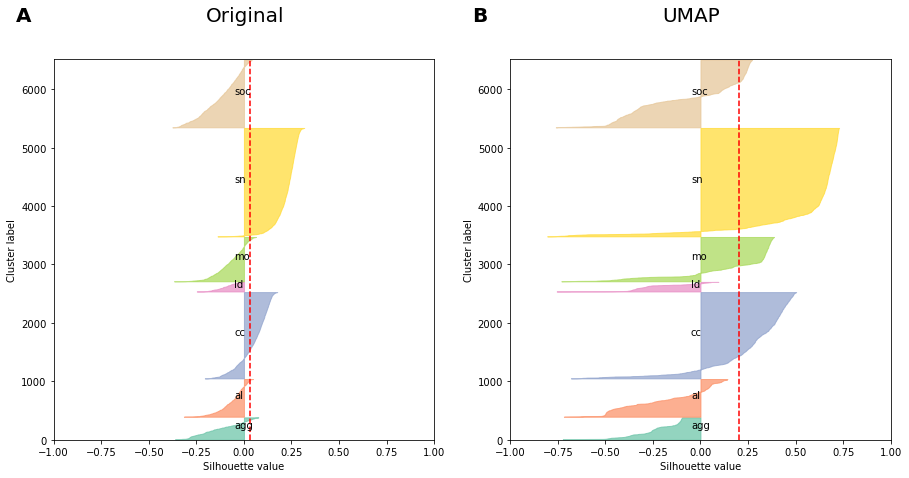

In [217]:
labeltypes = sorted(list(set(labels)))
n_clusters = len(labeltypes)


fig, (ax2, ax1) = plt.subplots(1, 2)
fig.set_size_inches(15, 7)

ax1.set_xlim([-1, 1])

ax1.set_ylim([0, embedding.shape[0] + (n_clusters + 1) * 10])
#cluster_labels = umap_df['HDBSCAN']
cluster_labels = labels
silhouette_avg = silhouette_score(embedding, cluster_labels)


# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(embedding, cluster_labels)
y_lower = 10

pal = sns.color_palette("Set2", n_colors=len(labeltypes))
color_dict = dict(zip(labeltypes, pal))


for i, cluster_label in enumerate(labeltypes):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == cluster_label]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i


    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                    0, ith_cluster_silhouette_values,
                    facecolor=color_dict[cluster_label], edgecolor=color_dict[cluster_label], alpha=0.7)
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, cluster_label)

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_xlabel("Silhouette value")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.text(-0.1, 1.1, string.ascii_uppercase[1], transform=ax1.transAxes, 
      size=20, weight='bold')

ax1.text(0.4, 1.1, "UMAP", transform=ax1.transAxes, 
      size=20)


##### ****************************************************
ax2.set_xlim([-1, 1])

ax2.set_ylim([0, original_embedding.shape[0] + (n_clusters + 1) * 10])
#cluster_labels = umap_df['HDBSCAN']
cluster_labels = labels
silhouette_avg = silhouette_score(original_embedding, cluster_labels)


# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(original_embedding, cluster_labels)
y_lower = 10

pal = sns.color_palette("Set2", n_colors=len(labeltypes))
color_dict = dict(zip(labeltypes, pal))


for i, cluster_label in enumerate(labeltypes):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == cluster_label]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i


    ax2.fill_betweenx(np.arange(y_lower, y_upper),
                    0, ith_cluster_silhouette_values,
                    facecolor=color_dict[cluster_label], edgecolor=color_dict[cluster_label], alpha=0.7)
    ax2.text(-0.05, y_lower + 0.5 * size_cluster_i, cluster_label)

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

#ax2.set_title("Original")
ax2.set_xlabel("Silhouette value")
ax2.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax2.axvline(x=silhouette_avg, color="red", linestyle="--")
ax2.text(-0.1, 1.1, string.ascii_uppercase[0], transform=ax2.transAxes, 
      size=20, weight='bold')
ax2.text(0.4, 1.1, "Original", transform=ax2.transAxes, 
      size=20)

#plt.show()
plt.savefig(os.path.join(os.path.sep,FIGURES,'paper_SIL_UMAP_original.png'), facecolor="white")

## Original space between and within distances

In [8]:
from scipy.spatial.distance import pdist, squareform

In [9]:
distmat_original = squareform(pdist(original_embedding, metric='euclidean'))
labels = np.asarray(labels)

self_dists={}
other_dists={}

for calltype in calltypes:
    x=distmat_original[np.where(labels==calltype)]
    x = np.transpose(x)  
    y = x[np.where(labels==calltype)]
   
    self_dists[calltype] = y[np.triu_indices(n=y.shape[0], m=y.shape[1],k = 1)]
    y = x[np.where(labels!=calltype)]
    other_dists[calltype] = y[np.triu_indices(n=y.shape[0], m=y.shape[1], k = 1)]

/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/reports/figures/paper_distanceswithinwithout_reduced_original.jpg


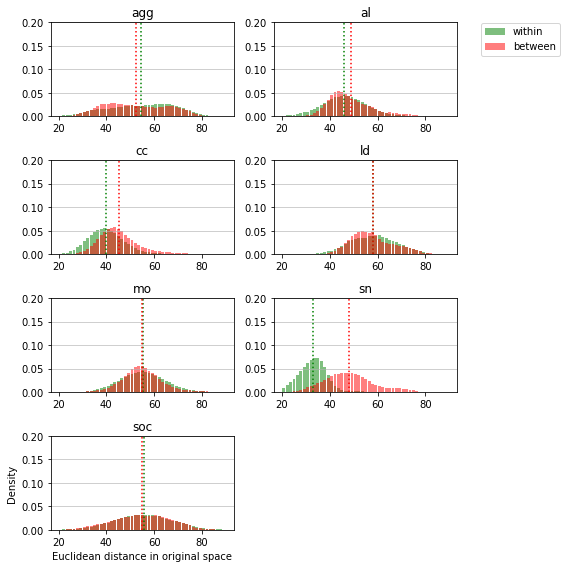

In [10]:
plt.figure(figsize=(8, 8))
i=1

xmin=20
xmax=90
nbins=50
    
for calltype in calltypes:
    
    plt.subplot(4, 2, i)
    n, bins, patches = plt.hist(x=self_dists[calltype], label="within", density=True,
                              #bins='auto', color='green',
                              bins=np.linspace(xmin, xmax, nbins), color='green',
                              alpha=0.5, rwidth=0.85)
    
    plt.vlines(x=np.mean(self_dists[calltype]),ymin=0,ymax=0.5,color='green', linestyles='dotted')

    n, bins, patches = plt.hist(x=other_dists[calltype], label="between", density=True,
                              bins=np.linspace(xmin, xmax, nbins), color='red',
                              #bins='auto', color='red',
                              alpha=0.5, rwidth=0.85)
  
    plt.vlines(x=np.mean(other_dists[calltype]),ymin=0,ymax=0.5,color='red', linestyles='dotted')
  
    s, pval = scipy.stats.ttest_ind(self_dists[calltype],other_dists[calltype])

    if pval<0.01:
        pval = "p<0.01"
    else:
        pval = "p="+str(round(pval,2))

    if i==2:
        plt.legend(loc='upper left', bbox_to_anchor=(1.1,1.05))
    plt.grid(axis='y', alpha=0.75)
    #plt.title(calltype+" ("+pval+")")
    plt.title(calltype)
    #plt.xlim(xmin,xmax)
    plt.ylim(0, 0.2)
    if i==len(calltypes):      
        plt.ylabel('Density')
        plt.xlabel('Euclidean distance in original space')

    i=i+1

#plt.subplot(4,2,i)
#plt.legend()

plt.tight_layout()
outname=os.path.join(os.path.sep, FIGURES, 'paper_distanceswithinwithout_reduced_original.jpg')
print(outname)
plt.savefig(outname)

In [11]:
# Do for UMAP space for comparison

distmat = squareform(pdist(embedding, metric='euclidean'))

self_dists_embedded={}
other_dists_embedded={}

for calltype in calltypes:
    x=distmat[np.where(labels==calltype)]
    x = np.transpose(x)  
    y = x[np.where(labels==calltype)]
   
    self_dists_embedded[calltype] = y[np.triu_indices(n=y.shape[0], m=y.shape[1],k = 1)]
    y = x[np.where(labels!=calltype)]
    other_dists_embedded[calltype] = y[np.triu_indices(n=y.shape[0], m=y.shape[1], k = 1)]

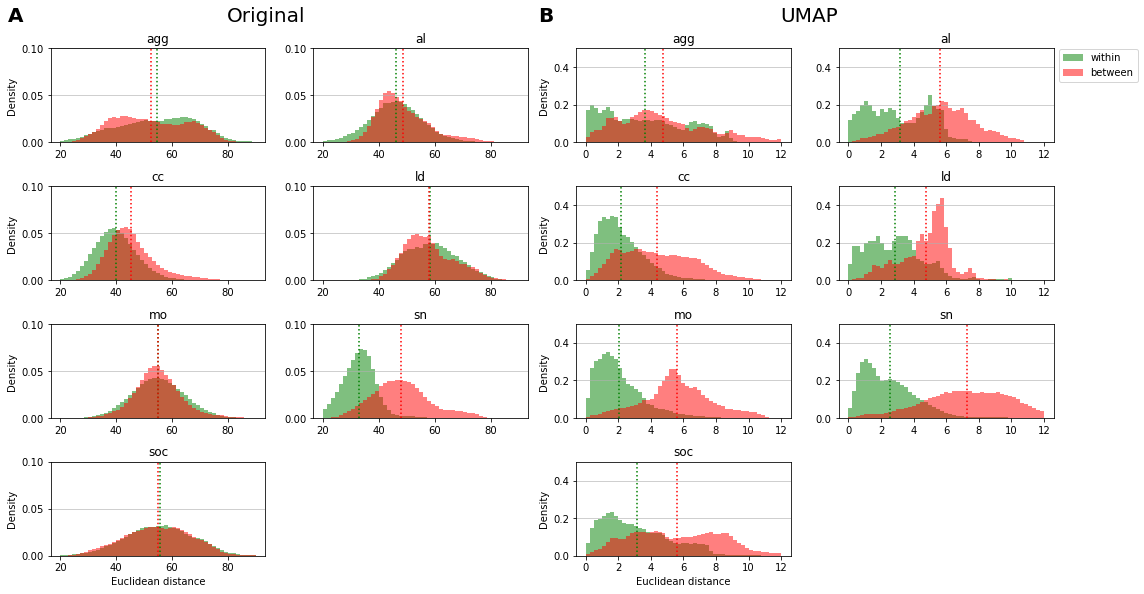

In [16]:
index_number = [1,2,5,6,9,10,13,3,4,7,8,11,12,15]

plt.figure(figsize=(16, 8))

xmin=20
xmax=90
nbins=50

ncols=4
nrows=4

dens = True

for i, calltype in zip(index_number[0:8], calltypes):

    plt.subplot(nrows, ncols, i)
    n, bins, patches = plt.hist(x=self_dists[calltype], label="within", density=dens,
                              bins=np.linspace(xmin, xmax, nbins), color='green',
                              alpha=0.5)#, rwidth=0.85)
    
    plt.vlines(x=np.mean(self_dists[calltype]),ymin=0,ymax=0.5,color='green', linestyles='dotted')

    n, bins, patches = plt.hist(x=other_dists[calltype], label="between", density=dens,
                              bins=np.linspace(xmin, xmax, nbins), color='red',
                              alpha=0.5)#, rwidth=0.85)
  
    plt.vlines(x=np.mean(other_dists[calltype]),ymin=0,ymax=0.5,color='red', linestyles='dotted')
    
    plt.grid(axis='y', alpha=0.75)
    plt.title(calltype)
    #plt.xlim(20,80)
    plt.ylim(0, 0.1)
    plt.yticks([0,0.05,0.1], ['0.00','0.05','0.10'])
    
    if i==13:      
        plt.xlabel('Euclidean distance')
    if i in [1,5,9,13]:
        plt.ylabel('Density')

xmin=0
xmax=12

for i, calltype in zip(index_number[7:], calltypes):

    plt.subplot(nrows, ncols, i)
    n, bins, patches = plt.hist(x=self_dists_embedded[calltype], label="within", density=dens,
                              bins=np.linspace(xmin, xmax, nbins), color='green',
                              alpha=0.5)#, rwidth=0.85)
    
    plt.vlines(x=np.mean(self_dists_embedded[calltype]),ymin=0,ymax=0.5,color='green', linestyles='dotted')

    n, bins, patches = plt.hist(x=other_dists_embedded[calltype], label="between", density=dens,
                              bins=np.linspace(xmin, xmax, nbins), color='red',
                              alpha=0.5)#,rwidth=0.85)
  
    plt.vlines(x=np.mean(other_dists_embedded[calltype]),ymin=0,ymax=0.5,color='red', linestyles='dotted')
  

    if i==4:
        plt.legend(loc='upper left', bbox_to_anchor=(1,1.05))
    
    plt.grid(axis='y', alpha=0.75)
    plt.title(calltype)
    plt.ylim(0, 0.5)
    
    if i==15: 
        plt.xlabel('Euclidean distance')
    if i in [3,7,11,15]:
        plt.ylabel('Density')

        
        
plt.figtext(0.2,1, "Original", size=20)
plt.figtext(0.68,1, "UMAP", size=20)

plt.figtext(0.01,1, "A", size=20, weight='bold')
plt.figtext(0.47,1, "B", size=20, weight='bold')


plt.tight_layout()
outname=os.path.join(os.path.sep, FIGURES, 'paper_distanceswithinwithout_reduced_original.jpg')
plt.savefig(outname, facecolor="white", bbox_inches='tight')

# Evaluation of structure preservation in embedding

## Nearest neighbor preservation

In [5]:
from evaluation_functions import get_knn

In [6]:
embedding_filename = os.path.join(os.path.sep, DATA,'basic_UMAP_3D_'+dftype+'_default_params.csv')
print(embedding_filename)
embedding = np.loadtxt(embedding_filename, delimiter=";")

/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/data/processed/basic_UMAP_3D_reduced_default_params.csv


In [7]:
k=10
indices, distances = get_knn(k,embedding)
indices_original, distance_original = get_knn(k, original_embedding)

In [32]:
for k in [1,2,3,4,5,6,7,8,9,10,15,20,30]:
    indices, distances = get_knn(k,embedding)
    indices_original, distance_original = get_knn(k, original_embedding)

    count_agree = 0
    count_disagree = 0

    for i in range(indices_original.shape[0]):
        for j in range(indices_original.shape[1]):
            # if original neighbor is also among nearest neighbors in UMAP space (indices)...
            if (indices_original[i,j] in indices[i,:]):
                count_agree += 1 # ...increase agreement_count
            else:
                count_disagree += 1
    
    print(k, ": ", count_agree, "/", count_disagree)
    print(k, ": ", count_agree/(count_agree+count_disagree))    

1 :  971 / 5459
1 :  0.1510108864696734
2 :  2642 / 10218
2 :  0.20544323483670296
3 :  4455 / 14835
3 :  0.23094867807153965
4 :  6344 / 19376
4 :  0.24665629860031105
5 :  8325 / 23825
5 :  0.25894245723172626
6 :  10366 / 28214
6 :  0.26868843960601346
7 :  12432 / 32578
7 :  0.27620528771384134
8 :  14508 / 36932
8 :  0.28203732503888024
9 :  16721 / 41149
9 :  0.288940729220667
10 :  18922 / 45378
10 :  0.2942768273716952
15 :  29942 / 66508
15 :  0.310440642820114
20 :  41009 / 87591
20 :  0.31888802488335927
30 :  64039 / 128861
30 :  0.3319803006739243


In [34]:
for k in [50,100]:
    indices, distances = get_knn(k,embedding)
    indices_original, distance_original = get_knn(k, original_embedding)

    count_agree = 0
    count_disagree = 0

    for i in range(indices_original.shape[0]):
        for j in range(indices_original.shape[1]):
            if (indices_original[i,j] in indices[i,:]):
                count_agree += 1
            else:
                count_disagree += 1
    
    print(k, ": ", count_agree, "/", count_disagree)
    print(k, ": ", count_agree/(count_agree+count_disagree))    

50 :  112385 / 209115
50 :  0.34956454121306374
100 :  245670 / 397330
100 :  0.38206842923794715


In [36]:
# EXTRA: Check how often neighbors in original space are at least among the k*2 nearest neighbors in UMAP space

for k in [1,2,3,4,5,6,7,8,9,10,15,20,30, 50, 100]:
    indices, distances = get_knn(k*2,embedding) 
    indices_original, distance_original = get_knn(k, original_embedding)

    count_agree = 0
    count_disagree = 0

    for i in range(indices_original.shape[0]):
        for j in range(indices_original.shape[1]):
            if (indices_original[i,j] in indices[i,:]):
                count_agree += 1
            else:
                count_disagree += 1
    
    print(k, ": ", count_agree, "/", count_disagree)
    print(k, ": ", count_agree/(k*original_embedding.shape[0]))  

1 :  1678 / 4752
1 :  0.2609642301710731
2 :  4248 / 8612
2 :  0.33032659409020215
3 :  6972 / 12318
3 :  0.3614307931570762
4 :  9771 / 15949
4 :  0.37989891135303266
5 :  12743 / 19407
5 :  0.3963608087091757
6 :  15723 / 22857
6 :  0.40754276827371694
7 :  18790 / 26220
7 :  0.417462786047545
8 :  21919 / 29521
8 :  0.4261080870917574
9 :  24959 / 32911
9 :  0.43129428028339384
10 :  28034 / 36266
10 :  0.4359875583203732
15 :  43745 / 52705
15 :  0.45355106272680146
20 :  59504 / 69096
20 :  0.462706065318818
30 :  93004 / 99896
30 :  0.48213582166925867
50 :  163994 / 157506
50 :  0.510090202177294
100 :  355155 / 287845
100 :  0.5523405909797823


## Mantel Test

Mantel test assesses the correlation between distance matrices --> use it to compare Euclidean distance in original space vs. in UMAP space.


In [24]:
from skbio.stats.distance import mantel
from scipy.spatial.distance import pdist, squareform

In [27]:
distmat = squareform(pdist(embedding, metric='euclidean'))
original_distmat = squareform(pdist(original_embedding, metric='euclidean'))

In [35]:
r,p,n = mantel(original_distmat, distmat, permutations=100, method='pearson')
print("Correlation coefficient: ", r)
print("P-value: ",p)

Correlation coefficient:  0.34174129168025613
P-value:  0.009900990099009901


In [65]:
r,p,n = mantel(original_distmat, distmat, permutations=100, method='spearman')
print("Correlation coefficient: ", r)
print("P-value: ",p)

Correlation coefficient:  0.34685121333399865
P-value:  0.009900990099009901


In [ ]:
r,p,n = mantel(original_distmat, distmat, method='pearson')
print("Correlation coefficient: ", r)
print("P-value: ",p)

In [ ]:
r,p,n = mantel(original_distmat, distmat, method='spearman')
print("Correlation coefficient: ", r)
print("P-value: ",p)

## Becht et al. figure

Box plots represent distances across pairs of points in the embeddings, binned using 50 equal-width bins over the pairwise distances in the original space using 10,000 randomly selected points, leading to 49,995,000 pairs of pairwise distances. The last row of graphs represents counts of pairwise distances in each bin of distances from the original space as histograms. The value of the Pearson correlation coefficient computed over the pairs of pairwise distances is reported. For the box plots, the central bar represents the median, and the top and bottom boundary of the boxes represent the 75th and 25th percentiles, respectively. The whiskers represent 1.5 times the interquartile range above (or, respectively, below) the top (or, respectively, bottom) box boundary, truncated to the data range if applicable.

https://www.nature.com/articles/nbt.4314#Sec7

https://www.biorxiv.org/content/10.1101/2019.12.19.877522v1



In [ ]:
# Generate 50 equal-width bins from the pairwise-distances in original space
# and assign each pairwise distance a bin (or make mask for each bin)

# Use the same mask to filter the paiwirse distances in embedded space
# Boxplot of the average distance in that area

# Plot all 50 boxplots next to each other

In [36]:
# Concatenate all relevant ones
all_dists = []

for i in range(original_distmat.shape[0]):
    all_dists.append(original_distmat[i,0:i])

all_dists_vec = np.hstack(all_dists).flatten()

In [37]:
all_dists_embedded = []

for i in range(distmat.shape[0]):
    all_dists_embedded.append(distmat[i,0:i])
all_dists_embedded_vec = np.hstack(all_dists_embedded).flatten()

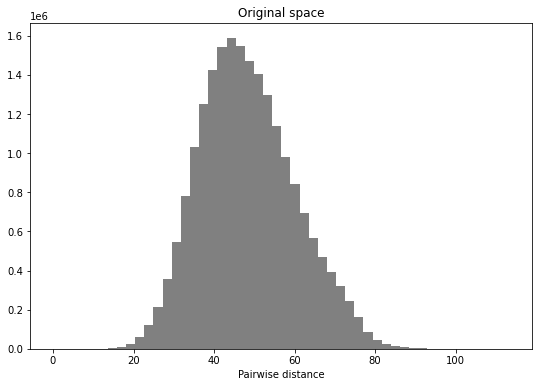

In [50]:
fig = plt.figure(1, figsize=(9, 6))
n, bins, batches = plt.hist(all_dists_vec, bins=50, color='grey')
plt.title('Original space')
plt.xlabel('Pairwise distance')
fig.savefig(os.path.join(os.path.sep,FIGURES,'dist_hist_original.png'), bbox_inches='tight')

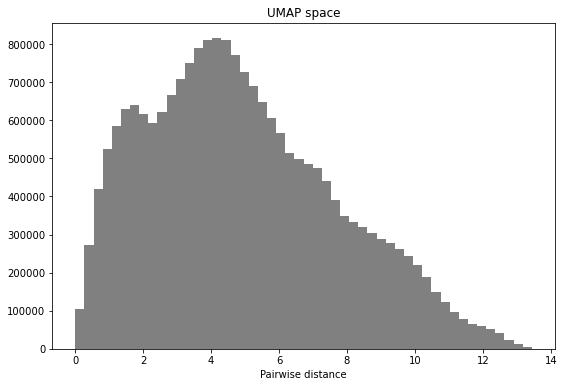

In [51]:
fig = plt.figure(1, figsize=(9, 6))
plt.title('UMAP space')
plt.xlabel('Pairwise distance')
n, bins, batches = plt.hist(all_dists_embedded_vec, bins=50, color='grey')
fig.savefig(os.path.join(os.path.sep,FIGURES,'dist_hist_umap.png'), bbox_inches='tight')

In [40]:
bins = np.linspace(np.min(all_dists_vec), np.max(all_dists_vec), 50)
bin_labels = np.digitize(all_dists_vec, bins)  
av_bin_labels = set(bin_labels)

In [41]:
bin_data_dict = {}
for bin_label in av_bin_labels:
    bin_data_dict[bin_label] = all_dists_embedded_vec[np.where(bin_labels==bin_label)]

In [ ]:
for i in np.arange(1,51,1):
    if i not in av_bin_labels:
#        print(i)
        bin_data_dict[i] = np.asarray([])

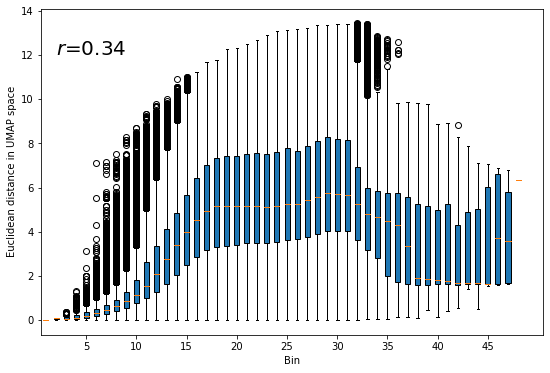

In [64]:
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(bin_data_dict.values(), patch_artist=True, showfliers=False)
ax.set_xlabel('Bin')
ax.set_ylabel('Euclidean distance in UMAP space')
ax.set_xticks(np.arange(5,50,5))
ax.set_xticklabels(np.arange(5,50,5))
t = ax.text(2, 12, '$r$=0.34', fontsize=20)
# Save the figure
fig.savefig(os.path.join(os.path.sep,FIGURES,'dist_corr_no_outliers.png'), bbox_inches='tight')

/home/mthomas/anaconda3/envs/meerkat_umap_env_3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/mthomas/anaconda3/envs/meerkat_umap_env_3/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(0.0, 12.0)

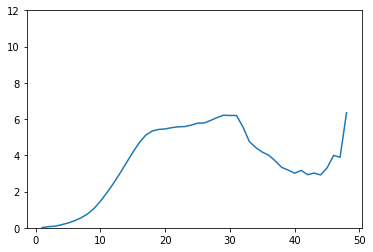

In [49]:
all_means = [np.mean(bin_data_dict[x]) for x in bin_data_dict.keys()]

plt.plot(np.arange(1,51,1), all_means)
plt.ylim(0,12)

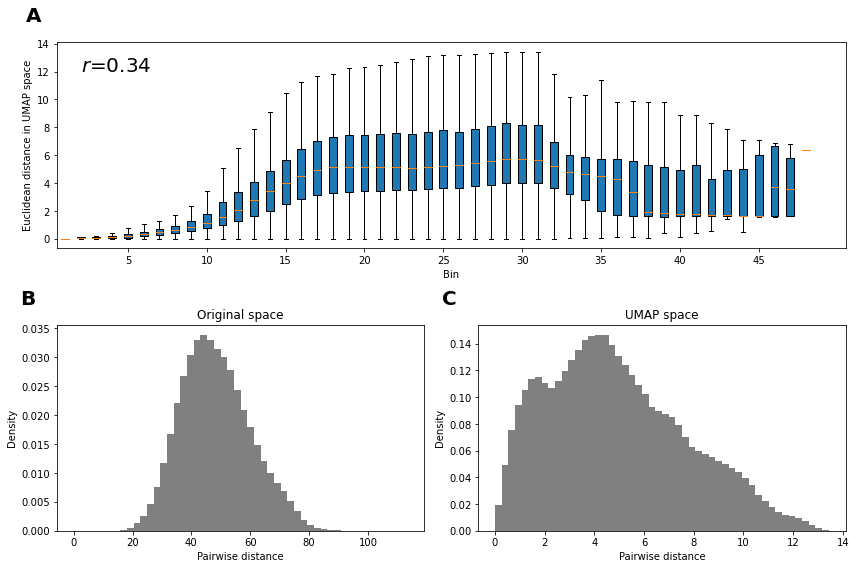

In [137]:
import string

plt.figure(figsize=(12,8))

ax1 = plt.subplot(2,2,3)
n, bins, batches = plt.hist(all_dists_vec, bins=50, color='grey', density=True)
plt.title('Original space')
plt.xlabel('Pairwise distance')
ax1.set_ylabel('Density')
ax1.text(-0.1, 1.1, string.ascii_uppercase[1], transform=ax1.transAxes, 
            size=20, weight='bold')

ax2 = plt.subplot(2,2,4)
ax2.set_title('UMAP space')
ax2.set_ylabel('Density')
ax2.set_xlabel('Pairwise distance')
n, bins, batches = plt.hist(all_dists_embedded_vec, bins=50, color='grey', density=True)
ax2.text(-0.1, 1.1, string.ascii_uppercase[2], transform=ax2.transAxes, 
            size=20, weight='bold')

ax3 = plt.subplot(2,1,1)
bp = ax3.boxplot(bin_data_dict.values(), patch_artist=True, showfliers=False)
ax3.set_xlabel('Bin')
ax3.set_ylabel('Euclidean distance in UMAP space')
ax3.set_xticks(np.arange(5,50,5))
ax3.set_xticklabels(np.arange(5,50,5))
t = ax3.text(2, 12, '$r$=0.34', fontsize=20)
ax3.text(-0.04, 1.1, string.ascii_uppercase[0], transform=ax3.transAxes, 
            size=20, weight='bold')

plt.tight_layout()
plt.savefig(os.path.join(os.path.sep,FIGURES, 'becht_plot.jpg'), facecolor="white")